# Katastrophensimulation - batch-run und Analyse
## Eigene Erweiterung des Systems [Aufgabe 6]

Als Erweiterung des Systems rund um die Simulation wählten wir eine erweiterte Auswertung des Systems.
Dafür nutzten wir die von Mesa bereitgestellten **batch-run** Möglichkeiten, mit welchen die Simulationen sehr oft und effizient ausgeführt werden konnten.
Anschließend wurden die generierten Daten mit **Pandas** in passende Formate umgewandelt und mit **Seaborn** (auf Matplotlib aufbauend) visualisiert.

In [1]:
import seaborn as sns
from schema import *
from typing import Dict, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
PICKLE_FILE = "./output/batch_results.pkl"

c:\Users\Völkl\Desktop\Dateien\Karriere\Studium\2. Symbolische KI 2\ProjectCatastrophe\Catastrophe-Simulator\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Aufsetzen des batch-runs

Für den batch-run können Paramter als Dictionary übergeben werden. Wenn die Parameter keine konstanten Werte, sondern Listen sind, so werden alle möglichen Kombinationen der Parameter durchlaufen. Schnell kann es dadurch zu tausenden Durchläufen kommen. 

In [2]:
# if iterables: tries all possible combinations of the parameters
parameters: Dict = {
    "width": range(8, 25, 2),
    "height": range(8, 25, 2),
    "n_survivors": range(1, 11),
    "n_save_zones": range(1, 11),
    "n_robot_agents": range(1, 7),
    "seed": 42,
}

# calculate the number of iterations for all parameters
count = 1
for key, value in parameters.items():
    # value can be a list or a range
    if isinstance(value, range):
        count *= len(list(value))
    elif isinstance(value, list):
        count *= len(value)
print("Count of combinations:", count)

Count of combinations: 48600


Mit Multiprocessing (Parameter _number\_processes_ von batch_run()) können jedoch mehrere Simulationen gleichzeitig ausgeführt werden, was die Simulationszeit deutlich reduziert. 
_Beispiel für den batch-run: 48600 Simulationen in 1:01:33 ergeben ca. 13 Simulationen pro Sekunde bei der Verwendung von zwölf logischen Prozessoren._

Besonders auffällig ist die hohe Geschwindigkeit der Simulationen bei geringen Höhen und Breiten des Labyrinths im Vergleich zu den hohen Rechendauern bei großen Labyrinthflächen. Vermutlich tritt dieser Unterschied wegen des erhöhten Rechenaufwands beim A-Stern Algorithmus für große Pfadlängen, wie es sie offensichtlich öfter bei großen Labyrinthen gibt, auf. 

Die Daten werden zur Aufbewahrung in einer pickle-Datei gespeichert und nur bei _run\_batch = True_ überschrieben.

In [ ]:
# if true -> run batch, save to pickle file in output folder
# if false -> load pickle file from output folder
run_batch = False

In [4]:
if run_batch:
    batch_results = mesa.batch_run(
        model_cls=EnvironmentModel,
        parameters=parameters,
        iterations=1, # for each possible combination of parameters
        number_processes=None,
        data_collection_period=-1,
        display_progress=True,
        max_steps=1000,
    )

100%|██████████| 48600/48600 [1:19:09<00:00, 10.23it/s]  


In [ ]:
df: pd.DataFrame = None

if run_batch:
    # save results to pickle file
    df = pd.DataFrame(batch_results)
    pd.DataFrame.to_pickle(df, PICKLE_FILE)
else:
    # load the results from the pickle file
    try:
        df = pd.DataFrame(pd.read_pickle(PICKLE_FILE))
    except:
        print("batch results not available, file not found, etc.")

print(f"The results have {len(df)} rows and {len(df.columns)} columns.")
print(df.columns)
df.head(2)

The results have 170100 rows and 29 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'seed', 'Survivors', 'SaveZones',
       'MazeWidth', 'MazeHeight', 'AllSurvivorsRescued', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'AgentID', 'Tile', 'TransportedSurvivor', 'TilesMoved',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'StillRunning'],
      dtype='object')


,RunId,iteration,Step,width,height,n_survivors,n_save_zones,n_robot_agents,seed,Survivors,...,TotalTilesMoved,TotalSurvivorsPickedUp,TotalSurvivorsPlacedDown,AgentID,Tile,TransportedSurvivor,TilesMoved,SurvivorsPickedUp,SurvivorsPlacedDown,StillRunning
0,0,0,4,8,8,1,1,1,42,[<schema.Survivor object at 0x000001B5CFD64440>],...,46,1,0,1,<schema.Tile object at 0x000001B5CE9BA990>,None,46,1,1,True
1,12,0,4,8,8,1,3,1,42,[<schema.Survivor object at 0x000001B5CE9BAC10>],...,29,1,0,1,<schema.Tile object at 0x000001B5CFD44E20>,None,29,1,1,True


## Data transformation

Die Daten werden mit Pandas in einem DataFrame für die Verwendung angepasst.

In [6]:
df.drop(
    [
        "seed", 
        "Survivors", 
        "MazeWidth", 
        "MazeHeight", 
        "AllSurvivorsRescued", 
        "Tile", 
        "StillRunning",
        "AgentID",
        "TransportedSurvivor",
        "TilesMoved"
    ],
    axis=1,
    inplace=True,
)
print(f"The results have reduced {len(df.columns)} columns.")
print(df.columns)

# get the ratio of TilesMoved per SurvivorCount as the column "TilesMovedPerSurvivor"
df["TilesMovedPerSurvivor"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_survivors"] if x["n_survivors"] > 0 else 0, axis=1
)

# get the ratio of TilesMoved per SaveZoneCount as the column "TilesMovedPerSaveZone"
df["TilesMovedPerSaveZone"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_save_zones"] if x["n_save_zones"] > 0 else 0,
    axis=1,
)

# get pathlengths parameters. only works if data_collection_period is set to 1
df["PathlengthMin"] = df.apply(
    lambda x: EnvironmentModel.get_min_pathlength(
        x["InitialPathlengths"]
    ),
    axis=1,
)
df["PathlengthMax"] = df.apply(
    lambda x: EnvironmentModel.get_max_pathlength(x["InitialPathlengths"]),
    axis=1,
)
df["PathlengthMean"] = df.apply(
    lambda x: EnvironmentModel.get_mean_pathlength(x["InitialPathlengths"]),
    axis=1,
)

# grouping of survivor / save zone / robot counts
df["SurvivorCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_survivors"] < 5 else "High (>=5)", axis=1
)
df["SaveZoneCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_save_zones"] < 5 else "High (>=5)", axis=1
)
df["RobotCountGroup"] = df.apply(
    lambda x: "Low (<4)" if x["n_robot_agents"] < 3 else "High (>=4)", axis=1
)

# height * width
df["MazeSize"] = df.apply(
    lambda x: x["width"] * x["height"], axis=1
)

The results have reduced 19 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown'],
      dtype='object')


## Data analysis
### Korrelationsmatrix

Mit einem [Seaborn-Beispiel](https://seaborn.pydata.org/archive/0.11/examples/many_pairwise_correlations.html) wird die Korrelationsmatrix der gesammelten Daten visualisiert.


Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'TilesMovedPerSurvivor',
       'TilesMovedPerSaveZone', 'PathlengthMin', 'PathlengthMax',
       'PathlengthMean', 'SurvivorCountGroup', 'SaveZoneCountGroup',
       'RobotCountGroup', 'MazeSize'],
      dtype='object')


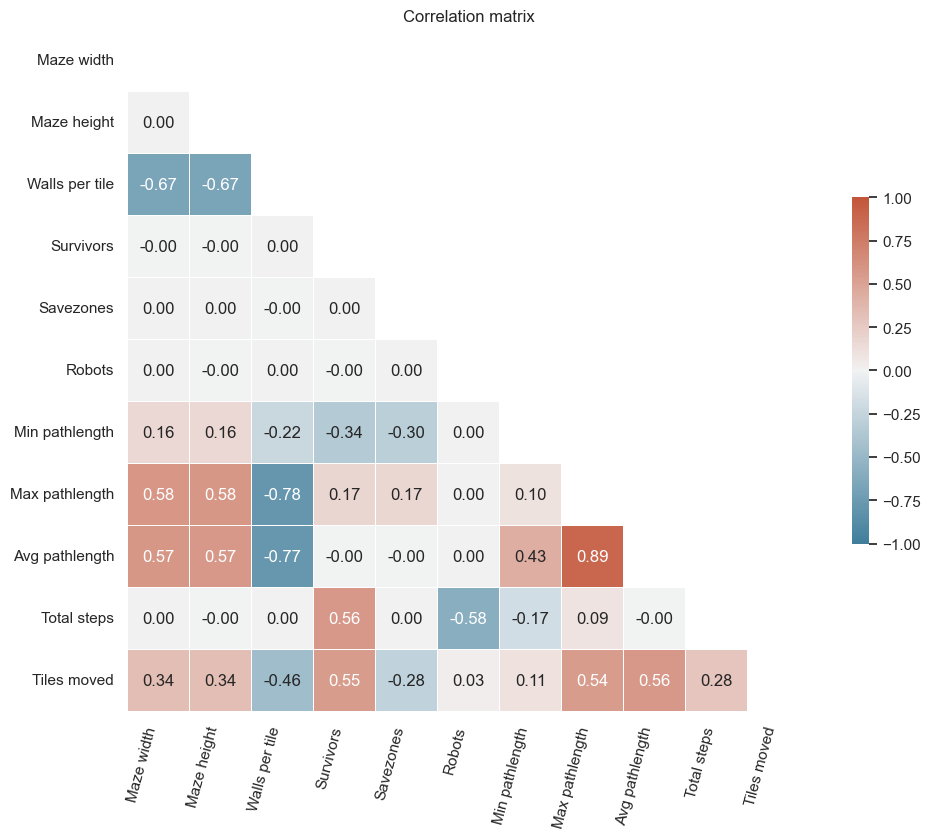

In [ ]:
# choose some columns
df_corr = df.reset_index()
df_corr = df_corr[
    [
        "width",
        "height",
        "MeanWallDensity",
        "n_survivors",
        "n_save_zones",
        "n_robot_agents",
        "PathlengthMin",
        "PathlengthMax",
        "PathlengthMean",
        "Step",
        "TotalTilesMoved",
    ]
]
df_corr.rename(
    columns={
        "width": "Maze width",
        "height": "Maze height",
        "MeanWallDensity": "Walls per tile",
        "n_survivors": "Survivors",
        "n_save_zones": "Savezones",
        "n_robot_agents": "Robots",
        "PathlengthMin": "Min pathlength",
        "PathlengthMax": "Max pathlength",
        "PathlengthMean": "Avg pathlength",
        "Step": "Total steps",
        "TotalTilesMoved": "Tiles moved",
    },
    inplace=True,
)

corr = df_corr.corr()

# Correlation matrix with mask for upper triangle
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
)
plt.title("Correlation matrix")
plt.xticks(rotation=75, ha="right")
plt.savefig("./output/correlation_heatmap.png", dpi=300, bbox_inches="tight");

>TODO: Analysiere die Korrelationsmatrix und beschreibe die Grafiken unten.

>erstelle evtl. eine Grafik für die Vermutung in der anderen file:
> Uns fiel in den Simulationen auf, dass isolierte SaveZones (*) oft eine Großzahl an Überlebenden beherbergen. Mit genug Simulationsdaten wäre diese Annahme interessant, zu überprüfen. Dafür müssten die Pfadlängen zwischen den SaveZones selbst und die am Ende beherbergten Überlebenden gesammelt und analysiert werden. 

### Impact of features on the total tiles moved
#### TilesMoved x Survivors

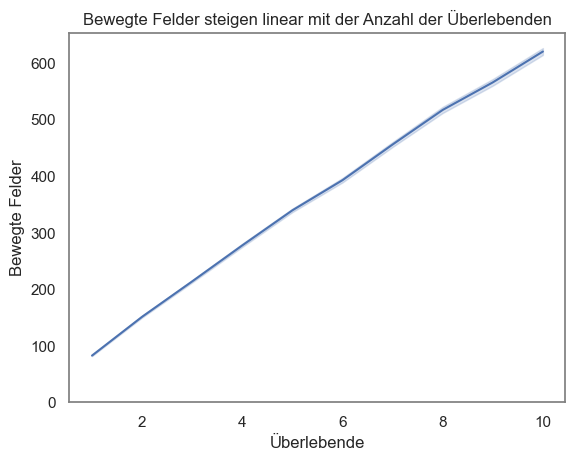

In [8]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved")
plt.title("Bewegte Felder steigen linear mit der Anzahl der Überlebenden")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")
    
plt.savefig("./output/tiles_moved_per_survivor.png", dpi=300, bbox_inches="tight")

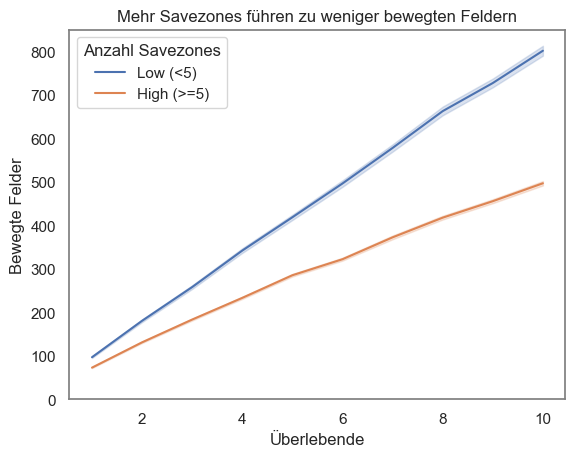

In [9]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="SaveZoneCountGroup")
plt.title("Mehr Savezones führen zu weniger bewegten Feldern")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)
plt.legend(title="Anzahl Savezones")
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/tiles_moved_per_survivor_grouped_savezones.png", dpi=300, bbox_inches="tight")

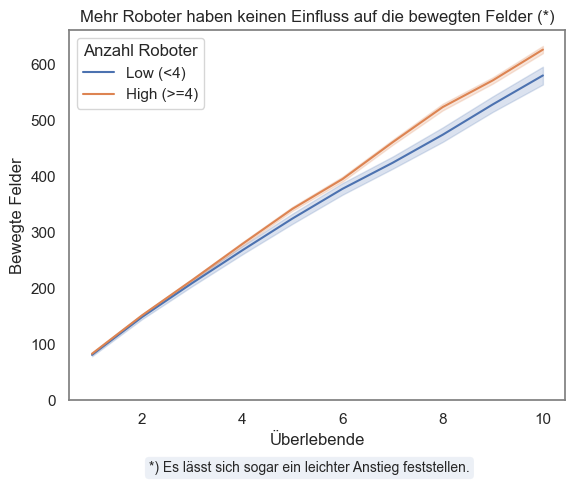

In [10]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="RobotCountGroup")
plt.title("Mehr Roboter haben keinen Einfluss auf die bewegten Felder (*)")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)

plt.legend(title="Anzahl Roboter")
plt.figtext(
    0.5,
    -0.04,
    "*) Es lässt sich sogar ein leichter Anstieg feststellen.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/tiles_moved_per_survivor_grouped_robots.png", dpi=300, bbox_inches="tight"
)

#### Pathlength x SaveZones

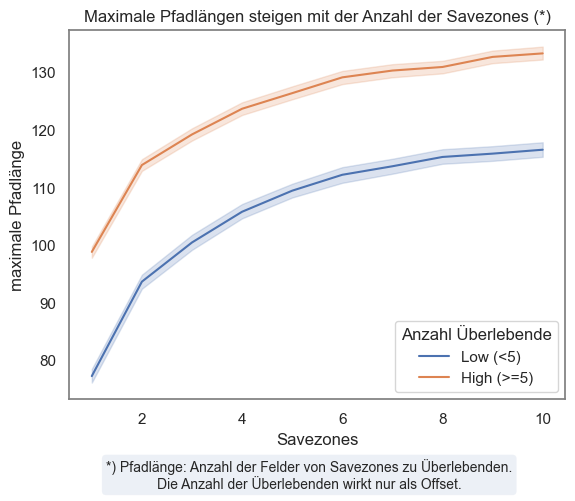

In [11]:
sns.lineplot(data=df, x="n_save_zones", y="PathlengthMax", hue="SurvivorCountGroup")

plt.title("Maximale Pfadlängen steigen mit der Anzahl der Savezones (*)")
plt.xlabel("Savezones")
plt.ylabel("maximale Pfadlänge")

plt.legend(title="Anzahl Überlebende")
plt.figtext(
    0.5,
    -0.07,
    "*) Pfadlänge: Anzahl der Felder von Savezones zu Überlebenden.\n" + 
    "Die Anzahl der Überlebenden wirkt nur als Offset.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/savezones_maxpathlengths_grouped_survivors.png", dpi=300, bbox_inches="tight"
)

#### Mazesize (width *height) x MovedTiles

In [12]:
df.columns

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'TilesMovedPerSurvivor',
       'TilesMovedPerSaveZone', 'PathlengthMin', 'PathlengthMax',
       'PathlengthMean', 'SurvivorCountGroup', 'SaveZoneCountGroup',
       'RobotCountGroup', 'MazeSize'],
      dtype='object')

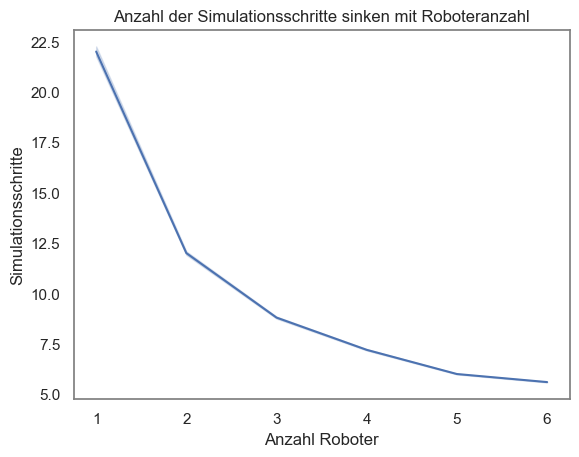

In [13]:
# 3 plots with same y axis
sns.lineplot(data=df, x="n_robot_agents", y="Step")


plt.title("Anzahl der Simulationsschritte sinken mit Roboteranzahl") # TODO: linear???
plt.xlabel("Anzahl Roboter")
plt.ylabel("Simulationsschritte")
plt.xticks(
    range(
        df["n_robot_agents"].min(),
        df["n_robot_agents"].max() + 1,
    )
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/simulationsteps_per_agent.png",
    dpi=300,
    bbox_inches="tight",
)